In [12]:
# Załadowanie bibliotek
library(tidyverse)
# - KNN
library(class)
library(caret)
# - Bayes
library(ROCR)
library(e1071)
# - Drzewa klasyfikacyjne
library(rpart)
library(rpart.plot)
library(tree)
# - Drzewa losowe
library(randomForest)
# - XGBoost
library(xgboost)
# - SVM

# Zaladowanie pakietu dummies
library(dummies)

Warning message:
"package 'tidyverse' was built under R version 4.4.2"
Warning message:
"package 'readr' was built under R version 4.4.2"
Warning message:
"package 'dplyr' was built under R version 4.4.2"
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
"package 'caret' was built under R version 4.4.2"
Loading required package: lattice


Attaching package: 'caret'


The following object is masked from 'package:purrr':

    lift


Warning message:
"package 'ROCR' was built under R version 4.4.2"
Warning 

In [14]:
# Definicja pliku url i plików z winem
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
red_file <- "winequality-red.csv"
white_file <- "winequality-white.csv"

# Pobieranie plików ze zbiorami
download.file(url, red_file)
download.file(gsub("red", "white", url), white_file)

# Pobranie zbioru z dodaniem informacji o kolorze wina
wine_red <- read_delim('winequality-red.csv', delim = ';') %>%
 mutate(is_red = 1)
wine_white <- read_delim('winequality-white.csv', delim = ';') %>%
 mutate(is_red = 0)

# Połączenie zbiorów wzdłuż wierszy
wine <- bind_rows(wine_red, wine_white)

# Zmiana nazw kolumn, zastąpienie spacji znakiem "_"
colnames(wine) <- gsub(" ", "_", colnames(wine))

# Zamiana wartości numerycznej factor
wine$quality <- factor(ifelse(wine$quality > 5, 'good', 'bad'))

# Sprawdzenie struktury danych
glimpse(wine)

# Podejrzenie początku danych
head(wine)

# Zapisanie kopii zbioru dla jego przywracania
wine_backup <- wine

Rows: 1599 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
dbl (12): fixed acidity, volatile acidity, citric acid, residual sugar, chlo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 4898 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
dbl (12): fixed acidity, volatile acidity, citric acid, residual sugar, chlo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 6,497
Columns: 13
$ fixed_acidity        <dbl> 7.4, 7.8, 7.8, 11.2, 7.4, 7.4, 7.9, 7.3, 7.8, 7.5…
$ volatile_acidity     <dbl> 0.700, 0.880, 0.760, 0.280, 0.700, 0.660, 0.600, …
$ citric_acid          <dbl> 0.00, 0.00, 0.04, 0.56, 0.00, 0.00, 0.06, 0.00, 0…
$ residual_sugar       <dbl> 1.9, 2.6, 2.3, 1.9, 1.9, 1.8, 1.6, 1.2, 2.0, 6.1,…
$ chlorides            <dbl> 0.076, 0.098, 0.092, 0.075, 0.076, 0.075, 0.069, …
$ free_sulfur_dioxide  <dbl> 11, 25, 15, 17, 11, 13, 15, 15, 9, 17, 15, 17, 16…
$ total_sulfur_dioxide <dbl> 34, 67, 54, 60, 34, 40, 59, 21, 18, 102, 65, 102,…
$ density              <dbl> 0.9978, 0.9968, 0.9970, 0.9980, 0.9978, 0.9978, 0…
$ pH                   <dbl> 3.51, 3.20, 3.26, 3.16, 3.51, 3.51, 3.30, 3.39, 3…
$ sulphates            <dbl> 0.56, 0.68, 0.65, 0.58, 0.56, 0.56, 0.46, 0.47, 0…
$ alcohol              <dbl> 9.4, 9.8, 9.8, 9.8, 9.4, 9.4, 9.4, 10.0, 9.5, 10.…
$ quality              <fct> bad, bad, bad, good, bad, bad, bad, good, good, b…
$ is_red        

fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,is_red
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,bad,1
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,bad,1
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,bad,1
11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,good,1
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,bad,1
7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,bad,1


In [39]:
##################################
# 1. K-najblizszych sasiadow     #
##################################

In [40]:
# -------------------- #
# Przygotowanie danych #
# -------------------- #

# Usuniecie obiektow dla czystego startu modelu
rm(list = setdiff(ls(), "wine_backup"))

# Przywrocenie zbioru z kopii
wine <- wine_backup

### Normalizacja zmiennych numerycznych

# Funkcja normalizujaca metoda min - max
normalize <- function(x) {
  return((x - min(x)) / (max(x) - min(x)))
}


# Zastosowanie funkcji normalizujacej dla kazdej zmiennej numerycznej
wine <- wine %>%
  mutate(across(where(is.numeric), normalize))

### Kodowanie zero jedynkowe zmiennych typu factor

# Zmiana obiektu z tibble na data.frame
wine <- data.frame(wine)

# Wydzielenie ze zbioru zmiennej objasnianej
wine_labels <- wine %>% select(quality)
wine <- wine %>% select(-quality)

# Podglad etykiet zmiennych
colnames(wine)

# Utworzenie ramki danych
wine <- as.data.frame(wine)

# Utworzenie zmiennych sztucznych dla zmiennych czynnikowych
factor_columns <- names(wine)[sapply(wine, is.factor)]
wine <- dummy.data.frame(data = wine, factor_columns, sep = "_")

###  Podzial zbioru na treningowy i testowy w proporcjach 75% do 25%

set.seed(1234)
sample_index <-
  sample(nrow(wine), round(nrow(wine) * .75), replace = FALSE)
wine_train <- wine[sample_index,]
wine_test <- wine[-sample_index,]

# Powtorzenie operacji dla zmiennej objasnianej heartDisease
wine_train_labels <- as.factor(wine_labels[sample_index,])
wine_test_labels <- as.factor(wine_labels[-sample_index,])

[1] "fixed_acidity"        "volatile_acidity"     "citric_acid"         
 [4] "residual_sugar"       "chlorides"            "free_sulfur_dioxide" 
 [7] "total_sulfur_dioxide" "density"              "pH"                  
[10] "sulphates"            "alcohol"              "is_red"

In [41]:
# ---------------- #
# Tworzenie modelu #
# ---------------- #

# Deklaracja wartosci k
k <- 15

### Budowa modelu KNN za pomoca funkcji knn() z pakietu class
wine_pred <-
  knn(
    train = wine_train,
    test = wine_test,
    cl = wine_train_labels,
    k = k
  )

# Podejrzenie pierwszych 6 elementów modelu
head(wine_pred)

[1] bad bad bad bad bad bad
Levels: bad good

Confusion Matrix and Statistics

          Reference
Prediction bad good
      bad  341  127
      good 282  874
                                          
               Accuracy : 0.7482          
                 95% CI : (0.7263, 0.7691)
    No Information Rate : 0.6164          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.4412          
                                          
 Mcnemar's Test P-Value : 2.641e-14       
                                          
            Sensitivity : 0.5474          
            Specificity : 0.8731          
         Pos Pred Value : 0.7286          
         Neg Pred Value : 0.7561          
             Prevalence : 0.3836          
         Detection Rate : 0.2100          
   Detection Prevalence : 0.2882          
      Balanced Accuracy : 0.7102          
                                          
       'Positive' Class : bad             
                           

[1] 0.8182411

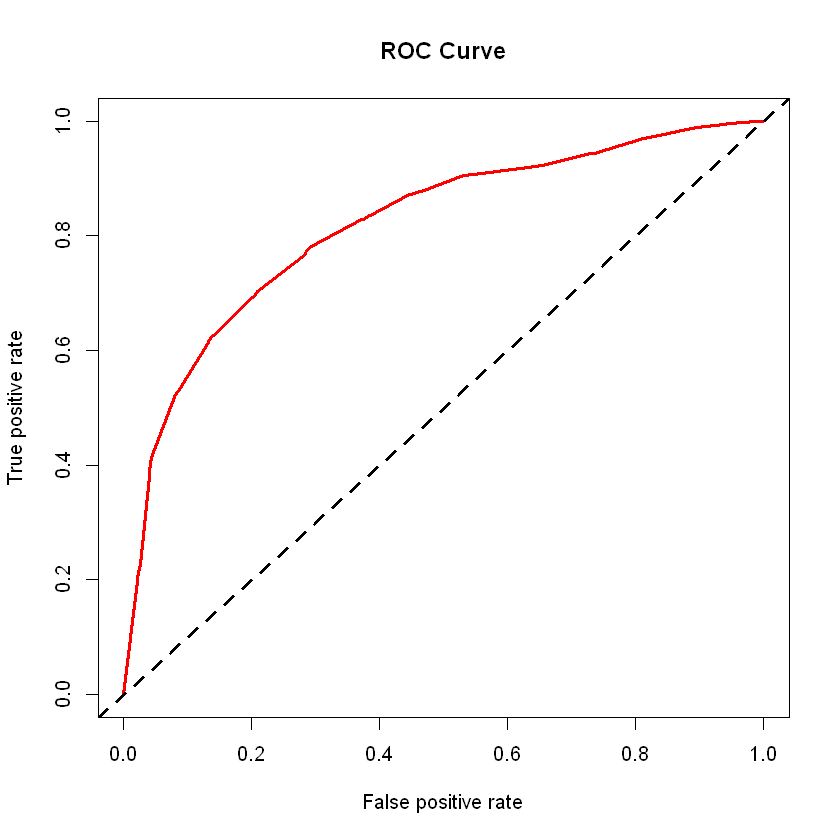

In [42]:
# ---------------- #
# Ewaluacja modelu #
# ---------------- #

### 1. Ewaluacja z wykorzystaniem macierzy pomylek
confusionMatrix(wine_pred, wine_test_labels)

### 2. Ewaluacja z wykorzystaniem krzywej ROC

# Trening modelu KNN
knn_model <- train(
  x = wine_train, 
  y = wine_train_labels, 
  method = "knn", 
  trControl = trainControl(method = "cv", number = 10),
  tuneGrid = expand.grid(k = k)  # Określenie wartości k
)

wine_pred_p <- predict(knn_model, wine_test, type = "prob")

roc_pred <-
  prediction(
    predictions = wine_pred_p[, 2],
    labels = wine_test_labels
  )

roc_perf <- performance(roc_pred, measure = "tpr", x.measure = "fpr")

plot(roc_perf, main = "ROC Curve", col = "red", lwd = 3)
abline(a = 0, b = 1, lwd = 3, lty = 2, col = 1)

### 3. Ewaluacja z wykorzystaniem wspolczynnika AUC

# Obliczanie pola pod krzywa ROC

# Wygenerowanie obiektu wydajnosci z parametrem measure = "auc"
auc_perf <- performance(roc_pred, measure = "auc")

# Wydobycie wartosci y.values ze slotu z obiektu auc_perf
wine_auc <- unlist(slot(auc_perf,"y.values"))
wine_auc

In [43]:
# ---------------- #
# Walidacja modelu #
# ---------------- #

### Walidacja krzyzowa k-krotna
knn_cv <- train(
  x = wine_train, 
  y = wine_train_labels, 
  method = "knn", 
  trControl = trainControl(method = "cv", number = 10)
)
print(knn_cv)

### Walidacja krzyzowa losowa
knn_boot <- train(
  x = wine_train, 
  y = wine_train_labels, 
  method = "knn", 
  trControl = trainControl(method = "boot", number = 100)
)
print(knn_boot)

k-Nearest Neighbors 

4873 samples
  12 predictor
   2 classes: 'bad', 'good' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 4385, 4386, 4385, 4385, 4386, 4386, ... 
Resampling results across tuning parameters:

  k  Accuracy   Kappa    
  5  0.7570249  0.4614062
  7  0.7560003  0.4566176
  9  0.7551852  0.4511348

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 5.
k-Nearest Neighbors 

4873 samples
  12 predictor
   2 classes: 'bad', 'good' 

No pre-processing
Resampling: Bootstrapped (100 reps) 
Summary of sample sizes: 4873, 4873, 4873, 4873, 4873, 4873, ... 
Resampling results across tuning parameters:

  k  Accuracy   Kappa    
  5  0.7283596  0.4012875
  7  0.7328576  0.4076421
  9  0.7363688  0.4133610

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 9.


In [44]:
##################################
# 2. Naiwny klasyfikator Bayesa  #
##################################

In [45]:
# -------------------- #
# Przygotowanie danych #
# -------------------- #

# Usuniecie obiektow dla czystego startu modelu
rm(list = setdiff(ls(), "wine_backup"))

# Przywrocenie zbioru z kopii
wine <- wine_backup

###  Podzial zbioru na treningowy i testowy w proporcjach 75% do 25%

set.seed(1234)
sample_index <-
  sample(nrow(wine), round(nrow(wine) * .75), replace = FALSE)
wine_train <- wine[sample_index,]
wine_test <- wine[-sample_index,]

# Sprawdzenie proporcji klas dla wszystkich trzech zbiorow
round(prop.table(table(select(wine, quality))),2)
round(prop.table(table(select(wine_train, quality))),2)
round(prop.table(table(select(wine_test, quality))),2)

quality
 bad good 
0.37 0.63 

quality
 bad good 
0.36 0.64 

quality
 bad good 
0.38 0.62 

In [46]:
# ---------------- #
# Tworzenie modelu #
# ---------------- #

### Budowa modelu za pomoca funkcji naiveBayes() z pakietu e1071
wine_mod <- naiveBayes(quality ~ ., data = wine_train, laplace = 1)
wine_mod

# Podstawienie danych testowych do modelu

wine_pred <- predict(wine_mod, wine_test, type = "class")
head(wine_pred)


Naive Bayes Classifier for Discrete Predictors

Call:
naiveBayes.default(x = X, y = Y, laplace = laplace)

A-priori probabilities:
Y
     bad     good 
0.361379 0.638621 

Conditional probabilities:
      fixed_acidity
Y          [,1]     [,2]
  bad  7.321692 1.275295
  good 7.168445 1.319152

      volatile_acidity
Y           [,1]      [,2]
  bad  0.4009994 0.1896505
  good 0.3072108 0.1394307

      citric_acid
Y           [,1]      [,2]
  bad  0.3025383 0.1623817
  good 0.3269794 0.1326866

      residual_sugar
Y          [,1]     [,2]
  bad  5.621437 4.942188
  good 5.298731 4.681868

      chlorides
Y            [,1]       [,2]
  bad  0.06499546 0.04566480
  good 0.05141902 0.02896202

      free_sulfur_dioxide
Y          [,1]     [,2]
  bad  29.41539 20.05540
  good 31.11648 16.59917

      total_sulfur_dioxide
Y          [,1]     [,2]
  bad  119.4458 62.07369
  good 113.5603 53.58068

      density
Y           [,1]        [,2]
  bad  0.9957275 0.002482757
  good 0.9941290 0.00

[1] bad bad bad bad bad bad
Levels: bad good

Confusion Matrix and Statistics

          Reference
Prediction bad good
      bad  299  189
      good 324  812
                                          
               Accuracy : 0.6841          
                 95% CI : (0.6609, 0.7067)
    No Information Rate : 0.6164          
    P-Value [Acc > NIR] : 7.620e-09       
                                          
                  Kappa : 0.3035          
                                          
 Mcnemar's Test P-Value : 3.294e-09       
                                          
            Sensitivity : 0.4799          
            Specificity : 0.8112          
         Pos Pred Value : 0.6127          
         Neg Pred Value : 0.7148          
             Prevalence : 0.3836          
         Detection Rate : 0.1841          
   Detection Prevalence : 0.3005          
      Balanced Accuracy : 0.6456          
                                          
       'Positive' Class : bad             
                           

[1] 0.753816

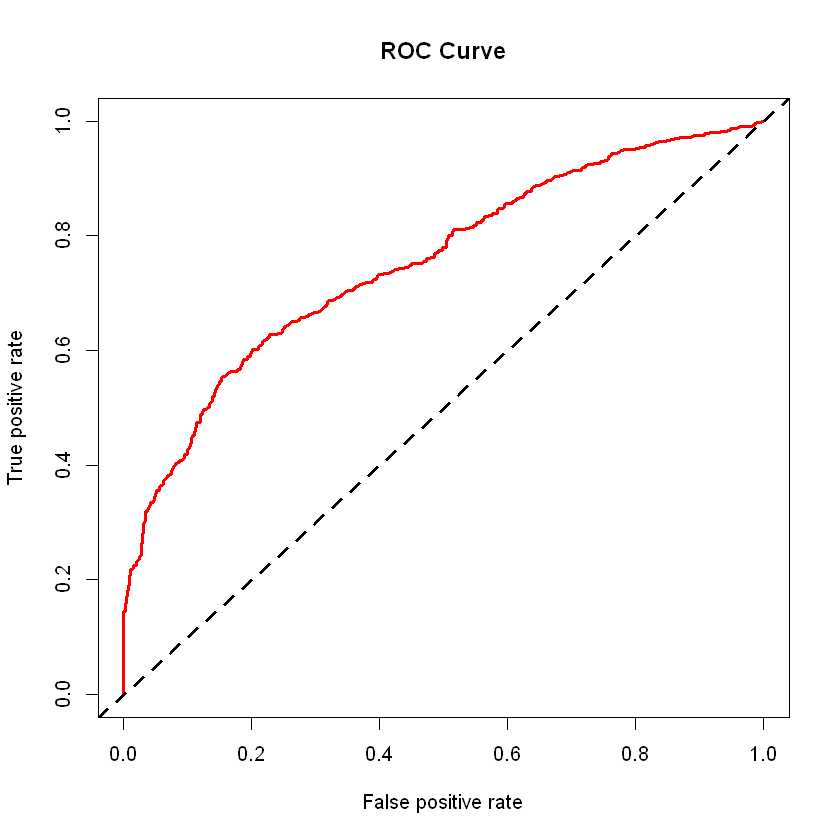

In [47]:
# ---------------- #
# Ewaluacja modelu #
# ---------------- #

### 1. Ewaluacja z wykorzystaniem macierzy pomylek
confusionMatrix(wine_pred, wine_test$quality)

### 2. Ewaluacja z wykorzystaniem krzywej ROC

wine_pred_p <- predict(wine_mod, wine_test, type = "raw")

roc_pred <-
  prediction(
    predictions = wine_pred_p[, "good"],
    labels = wine_test$quality
  )

roc_perf <- performance(roc_pred, measure = "tpr", x.measure = "fpr")

plot(roc_perf, main = "ROC Curve", col = "red", lwd = 3)
abline(a = 0, b = 1, lwd = 3, lty = 2, col = 1)

### 3. Ewaluacja z wykorzystaniem wspolczynnika AUC

# Wygenerowanie obiektu wydajnosci z parametrem measure = "auc"
auc_perf <- performance(roc_pred, measure = "auc")

# Wydobycie wartosci y.values ze slotu z obiektu auc_perf
wine_auc <- unlist(slot(auc_perf,"y.values"))
wine_auc

In [48]:
# ---------------- #
# Walidacja modelu #
# ---------------- #

### Walidacja krzyzowa k-krotna
train_control <- trainControl(method = "cv", number = 10)
wine_cv <- train(factor(quality) ~ ., data = wine, method = "naive_bayes", trControl = train_control)
print(wine_cv)

### Walidacja krzyzowa losowa
n_iterations <- 10
results <- vector("list", n_iterations)

for (i in 1:n_iterations) {
  # Losowy podział danych na zbiór treningowy i testowy
  train_index <- createDataPartition(wine$quality, p = 0.75, list = FALSE)
  wine_train <- wine[train_index,]
  wine_test <- wine[-train_index,]
  
  # Budowa modelu
  wine_mod <- naiveBayes(quality ~ ., data = wine_train, laplace = 1)
  
  # Predykcja
  wine_pred <- predict(wine_mod, wine_test, type = "class")
  
  # Obliczenie macierzy pomyłek
  cm <- confusionMatrix(wine_pred, wine_test$quality)
  results[[i]] <- cm$overall["Accuracy"]
}

# Średnia dokładność po 10 iteracjach
mean_accuracy <- mean(unlist(results))
print(mean_accuracy)

Naive Bayes 

6497 samples
  12 predictor
   2 classes: 'bad', 'good' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 5847, 5847, 5848, 5847, 5847, 5848, ... 
Resampling results across tuning parameters:

  usekernel  Accuracy   Kappa    
  FALSE      0.6777085  0.2908863
   TRUE      0.7044896  0.3696816

Tuning parameter 'laplace' was held constant at a value of 0
Tuning
 parameter 'adjust' was held constant at a value of 1
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were laplace = 0, usekernel = TRUE
 and adjust = 1.
[1] 0.6732759


In [49]:
##################################
# 3. Drzewa klasyfikacyjne       #
##################################

In [50]:
# -------------------- #
# Przygotowanie danych #
# -------------------- #

# Usuniecie obiektow dla czystego startu nastepnego modelu
rm(list = setdiff(ls(), "wine_backup"))

# Przywrocenie zbioru z kopii
wine <- wine_backup

###  Podzial zbioru na treningowy i testowy w proporcjach 75% do 25%

set.seed(1234)
sample_index <-
  sample(nrow(wine), round(nrow(wine) * .75), replace = FALSE)
wine_train <- wine[sample_index,]
wine_test <- wine[-sample_index,]

# Sprawdzenie proporcji klas dla wszystkich trzech zbiorow
round(prop.table(table(select(wine, quality))),2)
round(prop.table(table(select(wine_train, quality))),2)
round(prop.table(table(select(wine_test, quality))),2)

quality
 bad good 
0.37 0.63 

quality
 bad good 
0.36 0.64 

quality
 bad good 
0.38 0.62 

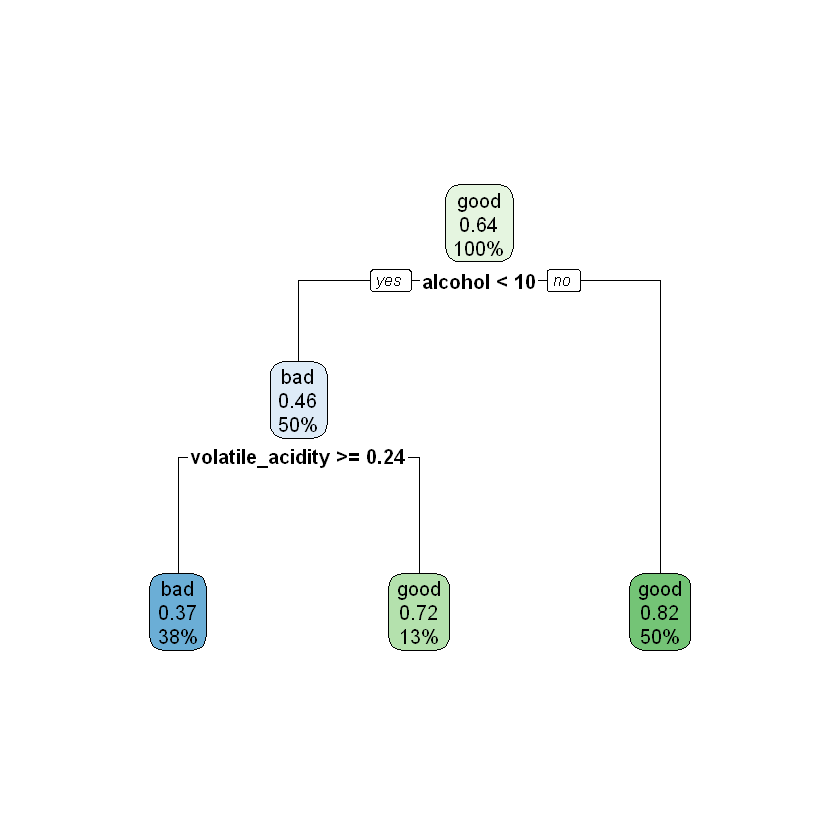

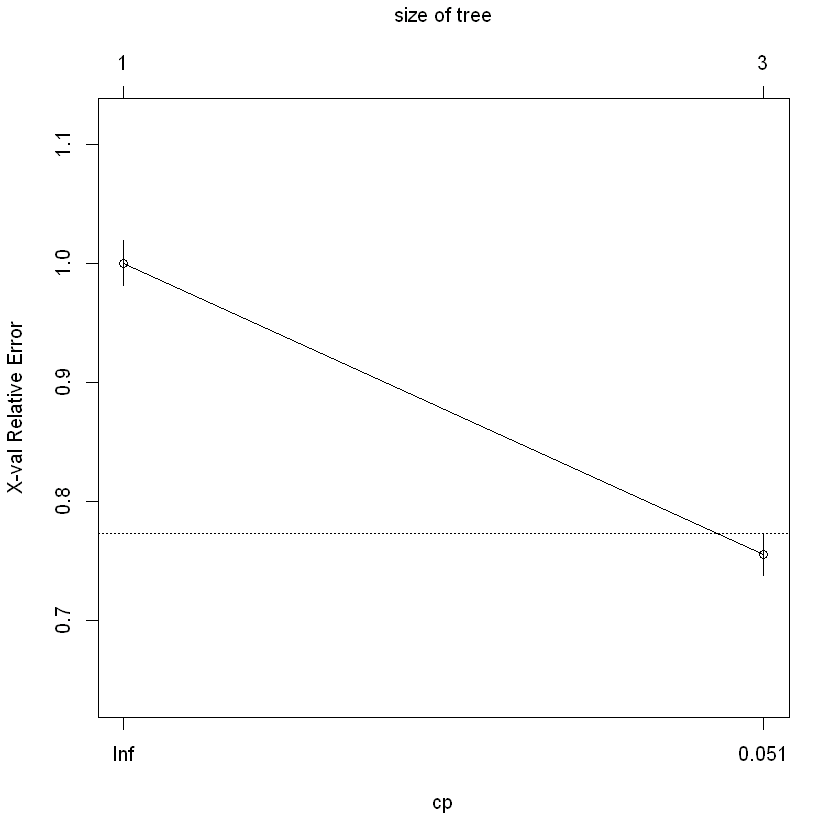

In [51]:
# ---------------- #
# Tworzenie modelu #
# ---------------- #

# Budowa modelu za pomoca funkcji rpart() z pakietu rpart ze wspolczynnikiem cp=0.02
wine_mod <-
  rpart(
    quality ~ .,
    method = "class",
    data = wine_train,
    cp = 0.02
  )

# Wygenerowanie wykresu drzewa
rpart.plot(wine_mod)

# Wygenerowanie wykresu bledu w zaleznosci od wspolczynnika cp
plotcp(wine_mod)

# Podstawienie do modelu wartosci ze zbioru testowego
wine_pred <- predict(wine_mod, wine_test, type = "class")

Confusion Matrix and Statistics

          Reference
Prediction bad good
      bad  403  197
      good 220  804
                                          
               Accuracy : 0.7432          
                 95% CI : (0.7212, 0.7643)
    No Information Rate : 0.6164          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.4532          
                                          
 Mcnemar's Test P-Value : 0.2813          
                                          
            Sensitivity : 0.6469          
            Specificity : 0.8032          
         Pos Pred Value : 0.6717          
         Neg Pred Value : 0.7852          
             Prevalence : 0.3836          
         Detection Rate : 0.2482          
   Detection Prevalence : 0.3695          
      Balanced Accuracy : 0.7250          
                                          
       'Positive' Class : bad             
                           

,bad,good
1,0.6251366,0.3748634
2,0.6251366,0.3748634
3,0.6251366,0.3748634
4,0.1832851,0.8167149
5,0.6251366,0.3748634
6,0.6251366,0.3748634


[1] 0.7337791

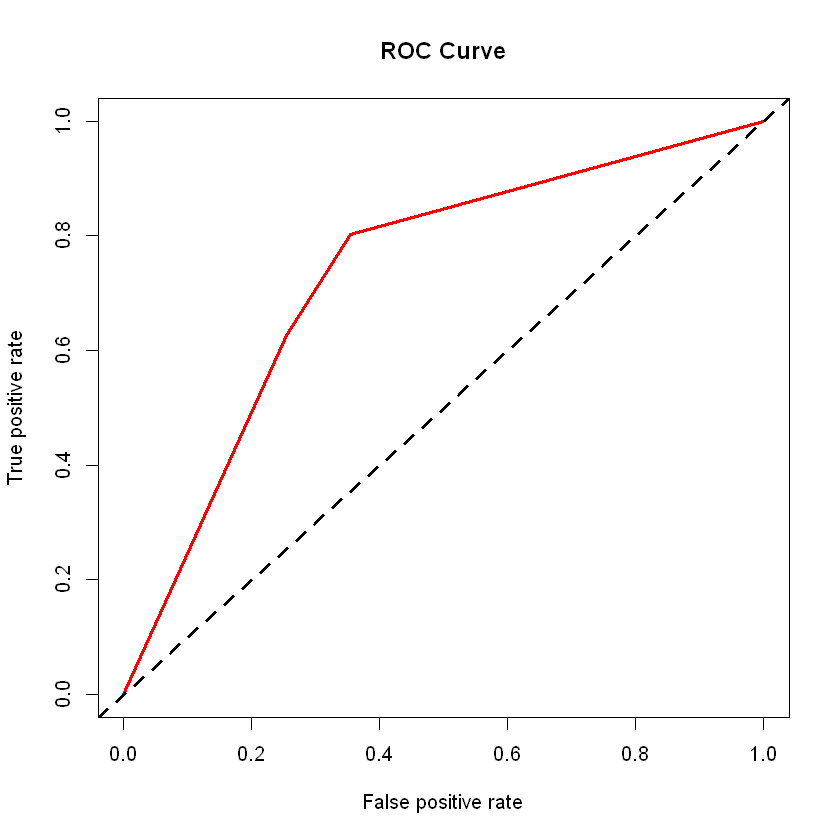

In [52]:
# ---------------- #
# Ewaluacja modelu #
# ---------------- #

### 1. Ewaluacja z wykorzystaniem macierzy pomylek
confusionMatrix(wine_pred, wine_test$quality)

### 2. Ewaluacja z wykorzystaniem krzywej ROC

# Predykcja wartosci prawdopodobienstw
wine_pred_p <- predict(wine_mod, wine_test, type = "prob")
head(wine_pred_p)

roc_pred <-
  prediction(
    predictions = wine_pred_p[, "good"],
    labels = wine_test$quality
  )

roc_perf <- performance(roc_pred, measure = "tpr", x.measure = "fpr")

plot(roc_perf, main = "ROC Curve", col = "red", lwd = 3)
abline(a = 0, b = 1, lwd = 3, lty = 2, col = 1)

### 3. Ewaluacja z wykorzystaniem wspolczynnika AUC

# Wygenerowanie obiektu wydajnosci z parametrem measure = "auc"
auc_perf <- performance(roc_pred, measure = "auc")

# Wydobycie wartosci y.values ze slotu z obiektu auc_perf
wine_auc <- unlist(slot(auc_perf,"y.values"))
wine_auc

In [53]:
# ---------------- #
# Walidacja modelu #
# ---------------- #

### Walidacja krzyzowa k-krotna
train_control <- trainControl(method = "cv", number = 5)
wine_cv <- train(quality ~ ., data = wine, method = "rf", trControl = train_control)
print(wine_cv)


### Walidacja krzyzowa losowa
train_control_random <- trainControl(method = "boot", number = 50)
wine_random_cv <- train(quality ~ ., data = wine, method = "rf", trControl = train_control_random)
print(wine_random_cv)

Random Forest 

6497 samples
  12 predictor
   2 classes: 'bad', 'good' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 5197, 5197, 5198, 5199, 5197 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   2    0.8391547  0.6465677
   7    0.8346898  0.6379090
  12    0.8333031  0.6354362

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 2.
Random Forest 

6497 samples
  12 predictor
   2 classes: 'bad', 'good' 

No pre-processing
Resampling: Bootstrapped (50 reps) 
Summary of sample sizes: 6497, 6497, 6497, 6497, 6497, 6497, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   2    0.8217759  0.6070525
   7    0.8178602  0.6006983
  12    0.8137097  0.5923091

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 2.


In [54]:
##################################
# 4. Lasy Losowe (Random Forest) #
##################################

In [55]:
# -------------------- #
# Przygotowanie danych #
# -------------------- #

# Usuniecie obiektow dla czystego startu nastepnego modelu
rm(list = setdiff(ls(), "wine_backup"))

# Przywrocenie zbioru z kopii
wine <- wine_backup

###  Podzial zbioru na treningowy i testowy w proporcjach 75% do 25%

set.seed(1234)
sample_index <-
  sample(nrow(wine), round(nrow(wine) * .75), replace = FALSE)
wine_train <- wine[sample_index,]
wine_test <- wine[-sample_index,]

# Sprawdzenie proporcji klas dla wszystkich trzech zbiorow
round(prop.table(table(select(wine, quality))),2)
round(prop.table(table(select(wine_train, quality))),2)
round(prop.table(table(select(wine_test, quality))),2)

quality
 bad good 
0.37 0.63 

quality
 bad good 
0.36 0.64 

quality
 bad good 
0.38 0.62 

In [56]:
# ---------------- #
# Tworzenie modelu #
# ---------------- #

# Budowa modelu za pomoca funkcji randomForest() z pakietu randomForest
wine_mod <- randomForest(quality ~ ., data = wine_train, ntrees=100)

wine_pred <- predict(wine_mod, wine_test, type = "class")

Confusion Matrix and Statistics

          Reference
Prediction bad good
      bad  431   85
      good 192  916
                                          
               Accuracy : 0.8294          
                 95% CI : (0.8102, 0.8474)
    No Information Rate : 0.6164          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6272          
                                          
 Mcnemar's Test P-Value : 1.904e-10       
                                          
            Sensitivity : 0.6918          
            Specificity : 0.9151          
         Pos Pred Value : 0.8353          
         Neg Pred Value : 0.8267          
             Prevalence : 0.3836          
         Detection Rate : 0.2654          
   Detection Prevalence : 0.3177          
      Balanced Accuracy : 0.8034          
                                          
       'Positive' Class : bad             
                           

,bad,good
1,0.780,0.220
2,0.812,0.188
3,0.784,0.216
4,0.904,0.096
5,0.802,0.198
6,0.706,0.294


[1] 0.9031963

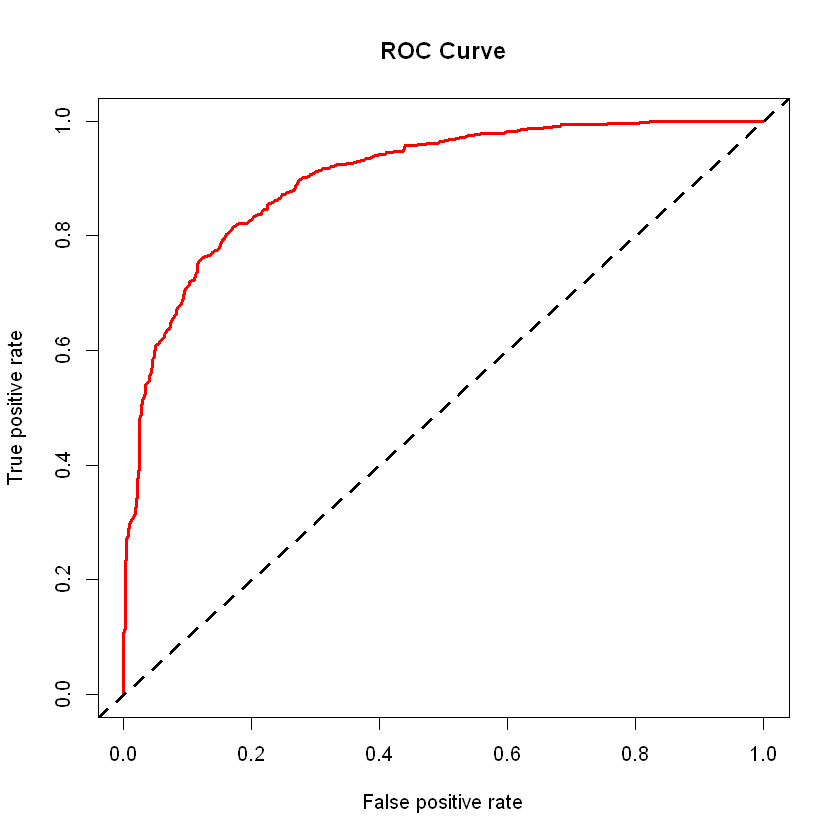

In [57]:
# ---------------- #
# Ewaluacja modelu #
# ---------------- #

### 1. Ewaluacja z wykorzystaniem macierzy pomylek
confusionMatrix(wine_pred, wine_test$quality)

### 2. Ewaluacja z wykorzystaniem krzywej ROC

# Predykcja wartosci prawdopodobienstw
wine_pred_p <- predict(wine_mod, wine_test, type = "prob")
head(wine_pred_p)

roc_pred <-
  prediction(
    predictions = wine_pred_p[, "good"],
    labels = wine_test$quality
  )

roc_perf <- performance(roc_pred, measure = "tpr", x.measure = "fpr")

plot(roc_perf, main = "ROC Curve", col = "red", lwd = 3)
abline(a = 0, b = 1, lwd = 3, lty = 2, col = 1)

### 3. Ewaluacja z wykorzystaniem wspolczynnika AUC

# Wygenerowanie obiektu wydajnosci z parametrem measure = "auc"
auc_perf <- performance(roc_pred, measure = "auc")

# Wydobycie wartosci y.values ze slotu z obiektu auc_perf
wine_auc <- unlist(slot(auc_perf, "y.values"))
wine_auc

In [ ]:
# ---------------- #
# Walidacja modelu #
# ---------------- #

### Walidacja krzyzowa k-krotna
train_control <- trainControl(method = "cv", number = 5)
wine_cv <- train(quality ~ ., data = wine, method = "rf", trControl = train_control)
print(wine_cv)


### Walidacja krzyzowa losowa
train_control_random <- trainControl(method = "boot", number = 50)
wine_random_cv <- train(quality ~ ., data = wine, method = "rf", trControl = train_control_random)
print(wine_random_cv)

Random Forest 

6497 samples
  12 predictor
   2 classes: 'bad', 'good' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 5197, 5198, 5197, 5198, 5198 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   2    0.8345411  0.6367434
   7    0.8343881  0.6382398
  12    0.8291536  0.6265583

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 2.


In [ ]:
##################################
# 5. Algorytm XGBoost            #
##################################

In [ ]:
# -------------------- #
# Przygotowanie danych #
# -------------------- #

# Usuniecie obiektow dla czystego startu nastepnego modelu
rm(list = setdiff(ls(), "wine_backup"))

# Przywrocenie zbioru z kopii
wine <- wine_backup

###  Podzial zbioru na treningowy i testowy w proporcjach 75% do 25%

set.seed(1234)
sample_index <-
  sample(nrow(wine), round(nrow(wine) * .75), replace = FALSE)
wine_train <- wine[sample_index,]
wine_test <- wine[-sample_index,]

# Sprawdzenie proporcji klas dla wszystkich trzech zbiorow
round(prop.table(table(select(wine, quality))),2)
round(prop.table(table(select(wine_train, quality))),2)
round(prop.table(table(select(wine_test, quality))),2)

In [ ]:
# ---------------- #
# Tworzenie modelu #
# ---------------- #

# Budowa modelu za pomoca funkcji randomForest() z pakietu randomForest

modelLookup("xgbTree")

wine_mod <- train(
  quality ~ .,
  data = wine_train,
  metric = "Accuracy",
  method = "xgbTree",
  trControl = trainControl(method = "none"),
  tuneGrid = expand.grid(
    nrounds = 100,
    max_depth = 6,
    eta = 0.3,
    gamma = 0.01,
    colsample_bytree = 1,
    min_child_weight = 1,
    subsample = 1
  )
)

wine_pred <- predict(wine_mod, wine_test, type = "raw")

In [ ]:
# ---------------- #
# Ewaluacja modelu #
# ---------------- #

### 1. Ewaluacja z wykorzystaniem macierzy pomylek
confusionMatrix(wine_pred, wine_test$quality)

### 2. Ewaluacja z wykorzystaniem krzywej ROC

# Predykcja wartosci prawdopodobienstw
wine_pred_p <- predict(wine_mod, wine_test, type = "prob")
head(wine_pred_p)

roc_pred <-
  prediction(
    predictions = wine_pred_p[, "good"],
    labels = wine_test$quality
  )

roc_perf <- performance(roc_pred, measure = "tpr", x.measure = "fpr")

plot(roc_perf, main = "ROC Curve", col = "red", lwd = 3)
abline(a = 0, b = 1, lwd = 3, lty = 2, col = 1)

### 3. Ewaluacja z wykorzystaniem wspolczynnika AUC

# Wygenerowanie obiektu wydajnosci z parametrem measure = "auc"
auc_perf <- performance(roc_pred, measure = "auc")

# Wydobycie wartosci y.values ze slotu z obiektu auc_perf
wine_auc <- unlist(slot(auc_perf,"y.values"))
wine_auc

In [ ]:
# ---------------- #
# Walidacja modelu #
# ---------------- #

### Walidacja krzyzowa k-krotna
cv_control <- trainControl(method = "cv", number = 10)
wine_mod_cv <- train(
  quality ~ .,
  data = wine_train,
  method = "xgbTree",
  metric = "Accuracy",
  trControl = cv_control,
  tuneGrid = expand.grid(
    nrounds = 100,
    max_depth = 6,
    eta = 0.3,
    gamma = 0.01,
    colsample_bytree = 1,
    min_child_weight = 1,
    subsample = 1
  )
)
print(wine_mod_cv)

### Walidacja krzyzowa losowa
random_control <- trainControl(method = "repeatedcv", number = 10, repeats = 3)
wine_mod_random <- train(
  quality ~ .,
  data = wine_train,
  method = "xgbTree",
  metric = "Accuracy",
  trControl = random_control,
  tuneGrid = expand.grid(
    nrounds = 100,
    max_depth = 6,
    eta = 0.3,
    gamma = 0.01,
    colsample_bytree = 1,
    min_child_weight = 1,
    subsample = 1
  )
)
print(wine_mod_random)

In [ ]:
##################################
# 6. Metoda SVM                  #
##################################

In [ ]:
# -------------------- #
# Przygotowanie danych #
# -------------------- #

# Usuniecie obiektow dla czystego startu nastepnego modelu
rm(list = setdiff(ls(), "wine_backup"))

# Przywrocenie zbioru z kopii
wine <- wine_backup

###  Podzial zbioru na treningowy i testowy w proporcjach 75% do 25%

set.seed(1234)
sample_index <-
  sample(nrow(wine), round(nrow(wine) * .75), replace = FALSE)
wine_train <- wine[sample_index,]
wine_test <- wine[-sample_index,]

# Sprawdzenie proporcji klas dla wszystkich trzech zbiorow
round(prop.table(table(select(wine, quality))),2)
round(prop.table(table(select(wine_train, quality))),2)
round(prop.table(table(select(wine_test, quality))),2)

In [ ]:
# ---------------- #
# Tworzenie modelu #
# ---------------- #

# Budowa modelu za pomoca funkcji randomForest() z pakietu randomForest
wine_mod <- svm(quality ~ ., data = wine_train, probability=TRUE)
print(wine_mod)

wine_pred <- predict(wine_mod, wine_test, type = "class")

In [ ]:
# ---------------- #
# Ewaluacja modelu #
# ---------------- #

### 1. Ewaluacja z wykorzystaniem macierzy pomylek
confusionMatrix(wine_pred, wine_test$quality)

### 2. Ewaluacja z wykorzystaniem krzywej ROC

# Predykcja wartosci , wazne aby ustawic parametry : 
# decision.values = TRUE, probability = TRUE
wine_pred <- predict(wine_mod, wine_test, decision.values = TRUE, probability = TRUE)

# Wyodrebnianie prawdopodobienstw
attr(wine_pred, "probabilities")[1:4,]

wine_pred_p <- attr(wine_pred, "probabilities")

roc_pred <-
  prediction(
    predictions = wine_pred_p[, "good"],
    labels = wine_test$quality
  )

roc_perf <- performance(roc_pred, measure = "tpr", x.measure = "fpr")

plot(roc_perf, main = "ROC Curve", col = "red", lwd = 3)
abline(a = 0, b = 1, lwd = 3, lty = 2, col = 1)

### 3. Ewaluacja z wykorzystaniem wspolczynnika AUC

# Wygenerowanie obiektu wydajnosci z parametrem measure = "auc"
auc_perf <- performance(roc_pred, measure = "auc")

# Wydobycie wartosci y.values ze slotu z obiektu auc_perf
wine_auc <- unlist(slot(auc_perf,"y.values"))
wine_auc

In [ ]:
# ---------------- #
# Walidacja modelu #
# ---------------- #

### Walidacja krzyzowa k-krotna
ctrl <- trainControl(method = "cv", number = 10)
wine_cv_mod <- train(quality ~ ., data = wine_train, method = "svmRadial", trControl = ctrl, probability = TRUE)
print(wine_cv_mod)

### Walidacja krzyzowa losowa
ctrl_random <- trainControl(method = "LGOCV", number = 10)
wine_random_mod <- train(quality ~ ., data = wine_train, method = "svmRadial", trControl = ctrl_random, probability = TRUE)
print(wine_random_mod)

In [16]:
############################################################################
############################################################################
# Realizacja analizy modeli z wykluczaniem zmiennych dla algorytmu XGBoost #
############################################################################
############################################################################

In [18]:
# Definicja funkcji do realizacji modelu XGBoost
run_xgboost <- function(excluded_column) {

##################################
# 5. Algorytm XGBoost            #
##################################

# -------------------- #
# Przygotowanie danych #
# -------------------- #

# Usuniecie obiektow dla czystego startu nastepnego modelu
rm(list = setdiff(ls(), "wine_backup"))

# Przywrocenie zbioru z kopii
wine <- wine_backup

### Usunięcie ze bioru wybranej kolumny
wine <- wine[, !(names(wine) %in% excluded_column)]

### Normalizacja zmiennych numerycznych

# Funkcja normalizujaca metoda min - max
normalize <- function(x) {
  return((x - min(x)) / (max(x) - min(x)))
}

# Zastosowanie funkcji normalizujacej dla kazdej zmiennej numerycznej
wine <- wine %>%
  mutate(across(where(is.numeric), normalize))

###  Podzial zbioru na treningowy i testowy w proporcjach 75% do 25%

set.seed(1234)
sample_index <-
  sample(nrow(wine), round(nrow(wine) * .75), replace = FALSE)
wine_train <- wine[sample_index,]
wine_test <- wine[-sample_index,]

# Sprawdzenie proporcji klas dla wszystkich trzech zbiorow
round(prop.table(table(select(wine, quality))),2)
round(prop.table(table(select(wine_train, quality))),2)
round(prop.table(table(select(wine_test, quality))),2)

# ---------------- #
# Tworzenie modelu #
# ---------------- #

# Budowa modelu za pomoca funkcji randomForest() z pakietu randomForest

modelLookup("xgbTree")

wine_mod <- train(
  quality ~ .,
  data = wine_train,
  metric = "Accuracy",
  method = "xgbTree",
  trControl = trainControl(method = "none"),
  tuneGrid = expand.grid(
    nrounds = 100,
    max_depth = 6,
    eta = 0.3,
    gamma = 0.01,
    colsample_bytree = 1,
    min_child_weight = 1,
    subsample = 1
  )
)

wine_pred <- predict(wine_mod, wine_test, type = "raw")

# ---------------- #
# Ewaluacja modelu #
# ---------------- #

### 1. Ewaluacja z wykorzystaniem macierzy pomylek
confusionMatrix(wine_pred, wine_test$quality)

### 2. Ewaluacja z wykorzystaniem krzywej ROC

# Predykcja wartosci prawdopodobienstw
wine_pred_p <- predict(wine_mod, wine_test, type = "prob")
head(wine_pred_p)

roc_pred <-
  prediction(
    predictions = wine_pred_p[, "good"],
    labels = wine_test$quality
  )

roc_perf <- performance(roc_pred, measure = "tpr", x.measure = "fpr")

plot(roc_perf, main = paste("ROC Curve for excluded", excluded_column), col = "red", lwd = 3)
abline(a = 0, b = 1, lwd = 3, lty = 2, col = 1)

### 3. Ewaluacja z wykorzystaniem wspolczynnika AUC

# Wygenerowanie obiektu wydajnosci z parametrem measure = "auc"
auc_perf <- performance(roc_pred, measure = "auc")

# Wydobycie wartosci y.values ze slotu z obiektu auc_perf
wine_auc <- unlist(slot(auc_perf,"y.values"))
wine_auc

# ---------------- #
# Walidacja modelu #
# ---------------- #

### Walidacja krzyzowa losowa
random_control <- trainControl(method = "repeatedcv", number = 10, repeats = 3)
wine_mod_random <- train(
  quality ~ .,
  data = wine_train,
  method = "xgbTree",
  metric = "Accuracy",
  trControl = random_control,
  tuneGrid = expand.grid(
    nrounds = 100,
    max_depth = 6,
    eta = 0.3,
    gamma = 0.01,
    colsample_bytree = 1,
    min_child_weight = 1,
    subsample = 1
  )
)
print(wine_mod_random)

}

In [20]:
# Pętla do uruchomienia modelu dla wszystkich cech
# for (excluded_column in setdiff(names(wine), "quality")) {
#   print("#####################################")
#   print(paste("run_xgboost for column:", excluded_column))
#   print("#####################################")
#   run_xgboost(excluded_column)
# }

In [22]:
# Uruchomienia pojedynczo dla każdej cechy

eXtreme Gradient Boosting 

4873 samples
  11 predictor
   2 classes: 'bad', 'good' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 4386, 4386, 4386, 4386, 4385, 4386, ... 
Resampling results:

  Accuracy  Kappa    
  0.812989  0.5882496

Tuning parameter 'nrounds' was held constant at a value of 100
Tuning
 held constant at a value of 1
Tuning parameter 'subsample' was held
 constant at a value of 1


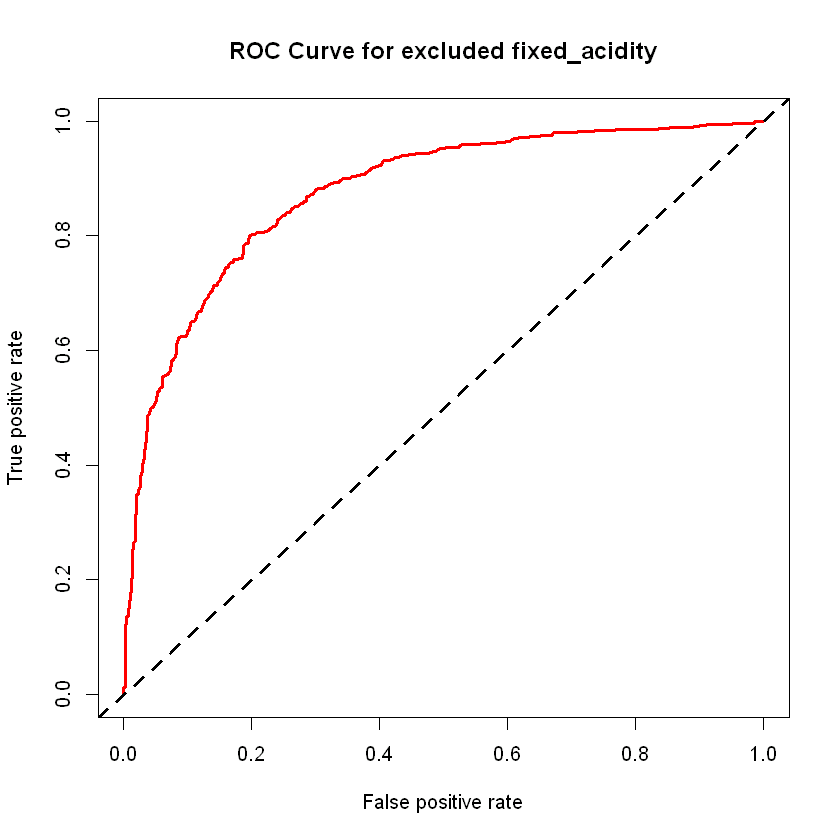

In [24]:
excluded_column <- "fixed_acidity"
run_xgboost(excluded_column)

eXtreme Gradient Boosting 

4873 samples
  11 predictor
   2 classes: 'bad', 'good' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 4386, 4386, 4386, 4386, 4385, 4386, ... 
Resampling results:

  Accuracy   Kappa    
  0.8038224  0.5688789

Tuning parameter 'nrounds' was held constant at a value of 100
Tuning
 held constant at a value of 1
Tuning parameter 'subsample' was held
 constant at a value of 1


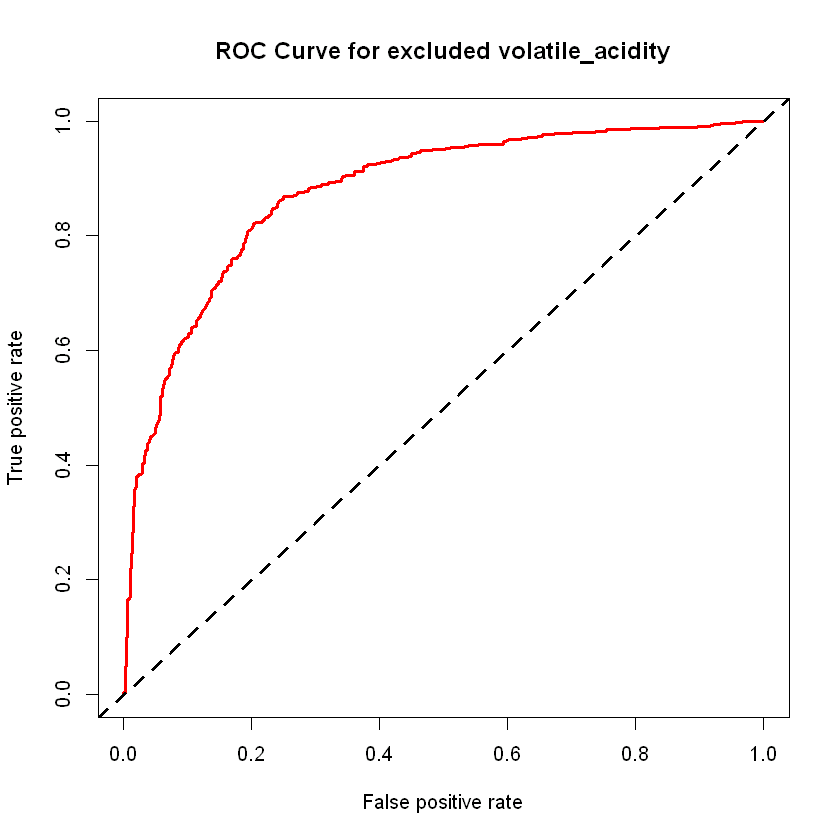

In [25]:
excluded_column <- "volatile_acidity"
run_xgboost(excluded_column)

eXtreme Gradient Boosting 

4873 samples
  11 predictor
   2 classes: 'bad', 'good' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 4386, 4386, 4386, 4386, 4385, 4386, ... 
Resampling results:

  Accuracy   Kappa    
  0.8135342  0.5911302

Tuning parameter 'nrounds' was held constant at a value of 100
Tuning
 held constant at a value of 1
Tuning parameter 'subsample' was held
 constant at a value of 1


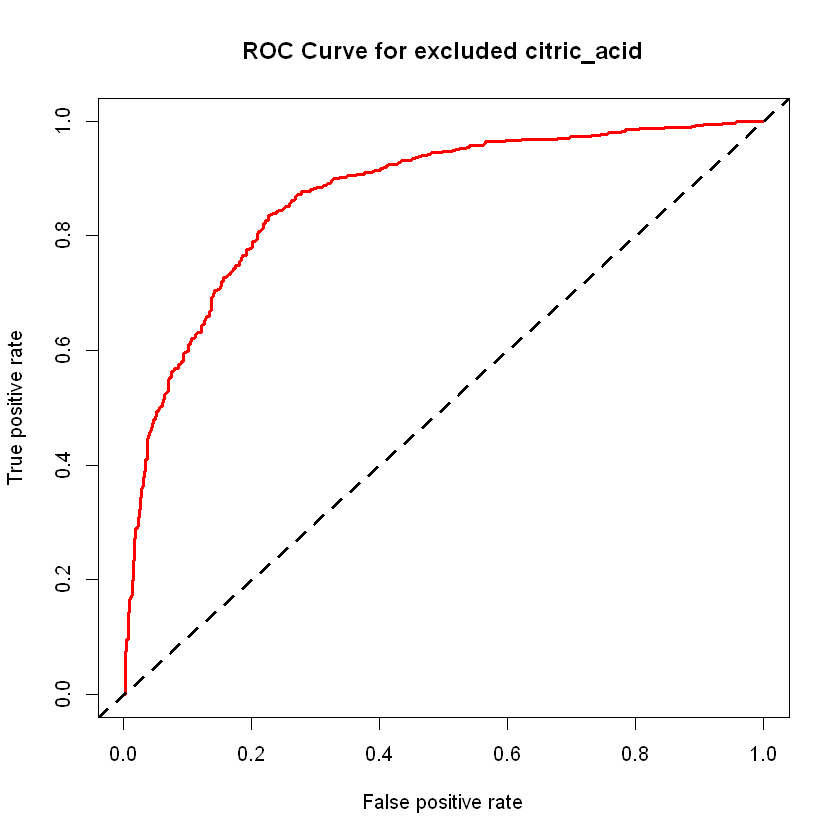

In [26]:
excluded_column <- "citric_acid"
run_xgboost(excluded_column)

eXtreme Gradient Boosting 

4873 samples
  11 predictor
   2 classes: 'bad', 'good' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 4386, 4386, 4386, 4386, 4385, 4386, ... 
Resampling results:

  Accuracy  Kappa    
  0.813121  0.5884298

Tuning parameter 'nrounds' was held constant at a value of 100
Tuning
 held constant at a value of 1
Tuning parameter 'subsample' was held
 constant at a value of 1


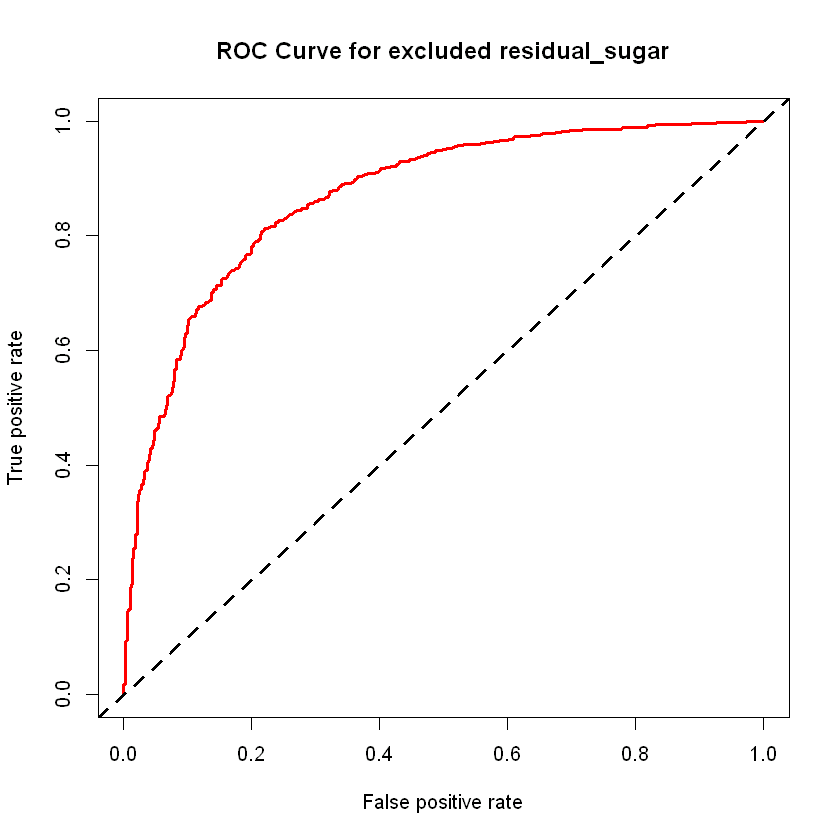

In [27]:
excluded_column <- "residual_sugar"
run_xgboost(excluded_column)

eXtreme Gradient Boosting 

4873 samples
  11 predictor
   2 classes: 'bad', 'good' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 4386, 4386, 4386, 4386, 4385, 4386, ... 
Resampling results:

  Accuracy   Kappa    
  0.8097715  0.5809504

Tuning parameter 'nrounds' was held constant at a value of 100
Tuning
 held constant at a value of 1
Tuning parameter 'subsample' was held
 constant at a value of 1


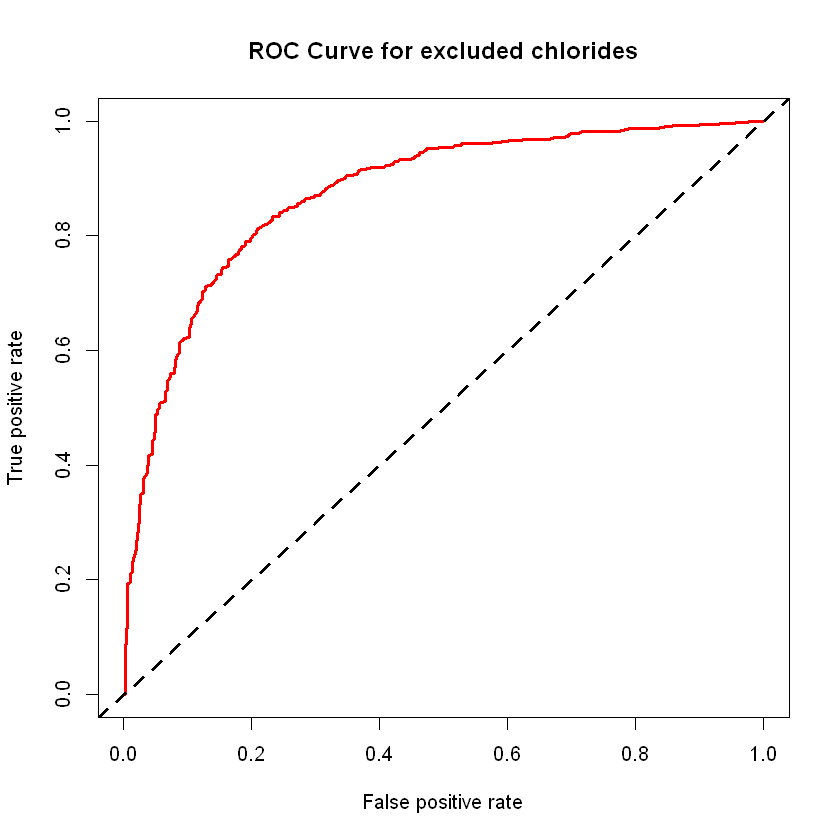

In [28]:
excluded_column <- "chlorides"
run_xgboost(excluded_column)

eXtreme Gradient Boosting 

4873 samples
  11 predictor
   2 classes: 'bad', 'good' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 4386, 4386, 4386, 4386, 4385, 4386, ... 
Resampling results:

  Accuracy   Kappa    
  0.8068976  0.5737081

Tuning parameter 'nrounds' was held constant at a value of 100
Tuning
 held constant at a value of 1
Tuning parameter 'subsample' was held
 constant at a value of 1


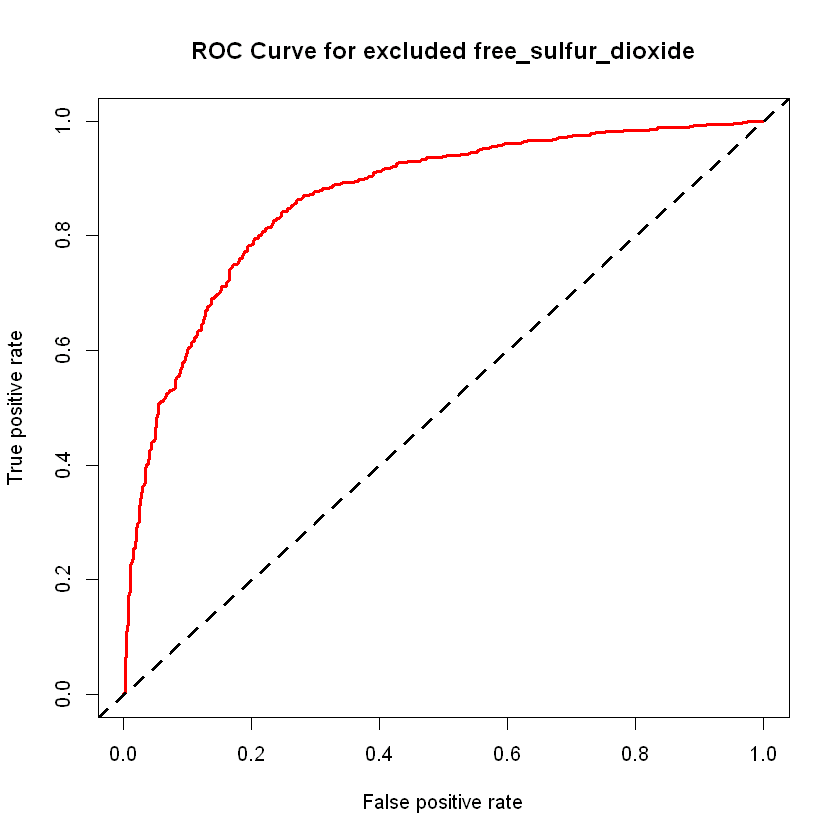

In [29]:
excluded_column <- "free_sulfur_dioxide"
run_xgboost(excluded_column)

eXtreme Gradient Boosting 

4873 samples
  11 predictor
   2 classes: 'bad', 'good' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 4386, 4386, 4386, 4386, 4385, 4386, ... 
Resampling results:

  Accuracy  Kappa   
  0.803612  0.568218

Tuning parameter 'nrounds' was held constant at a value of 100
Tuning
 held constant at a value of 1
Tuning parameter 'subsample' was held
 constant at a value of 1


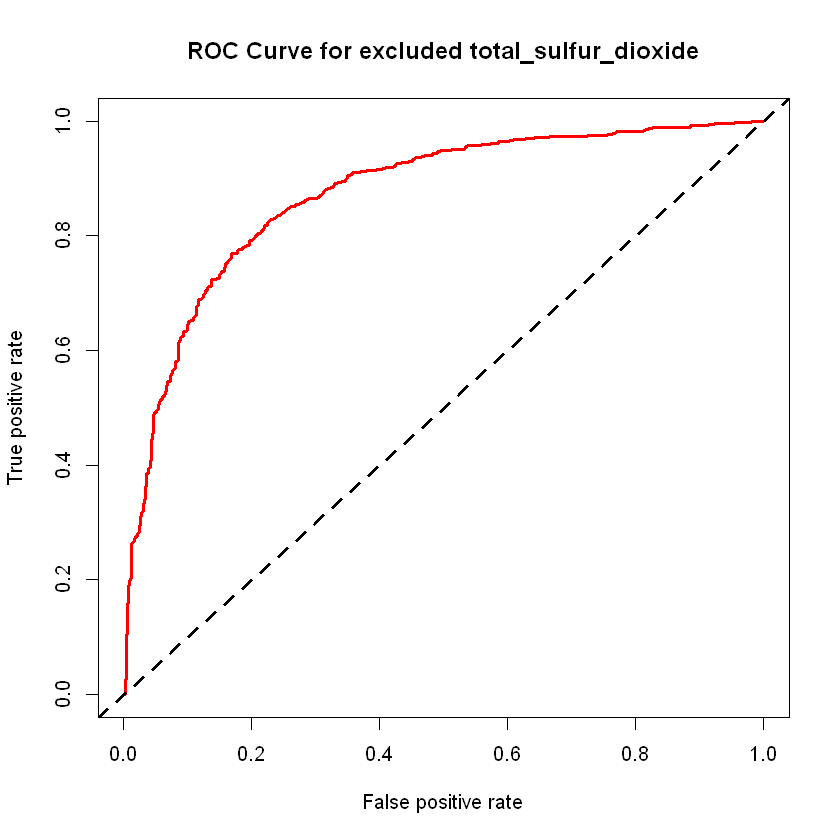

In [30]:
excluded_column <- "total_sulfur_dioxide"
run_xgboost(excluded_column)

eXtreme Gradient Boosting 

4873 samples
  11 predictor
   2 classes: 'bad', 'good' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 4386, 4386, 4386, 4386, 4385, 4386, ... 
Resampling results:

  Accuracy   Kappa    
  0.8159283  0.5940811

Tuning parameter 'nrounds' was held constant at a value of 100
Tuning
 held constant at a value of 1
Tuning parameter 'subsample' was held
 constant at a value of 1


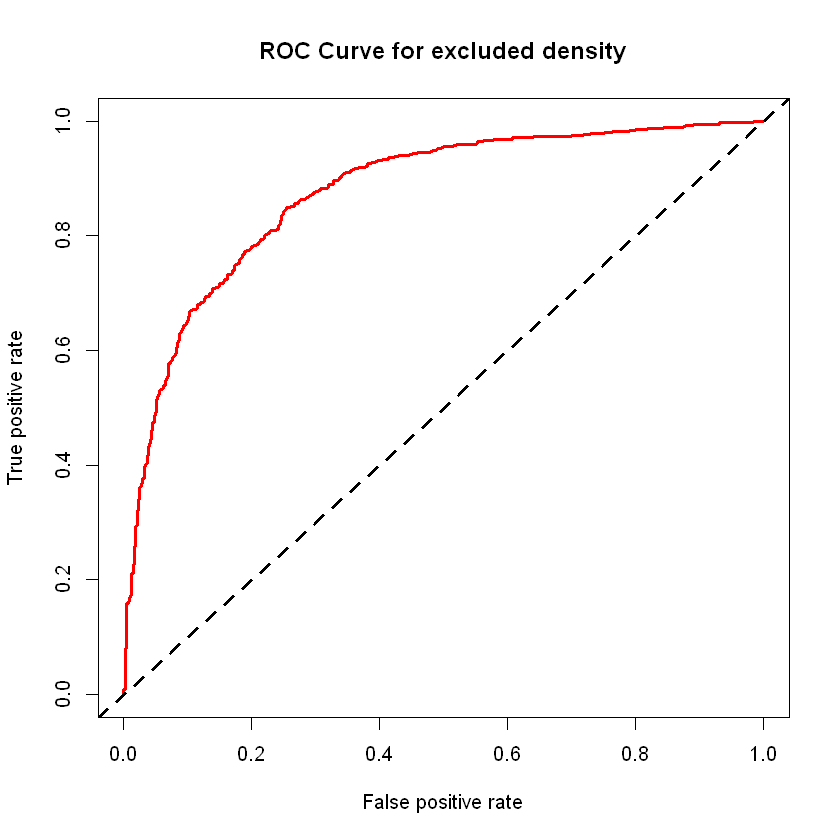

In [31]:
excluded_column <- "density"
run_xgboost(excluded_column)

eXtreme Gradient Boosting 

4873 samples
  11 predictor
   2 classes: 'bad', 'good' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 4386, 4386, 4386, 4386, 4385, 4386, ... 
Resampling results:

  Accuracy   Kappa    
  0.8148344  0.5921647

Tuning parameter 'nrounds' was held constant at a value of 100
Tuning
 held constant at a value of 1
Tuning parameter 'subsample' was held
 constant at a value of 1


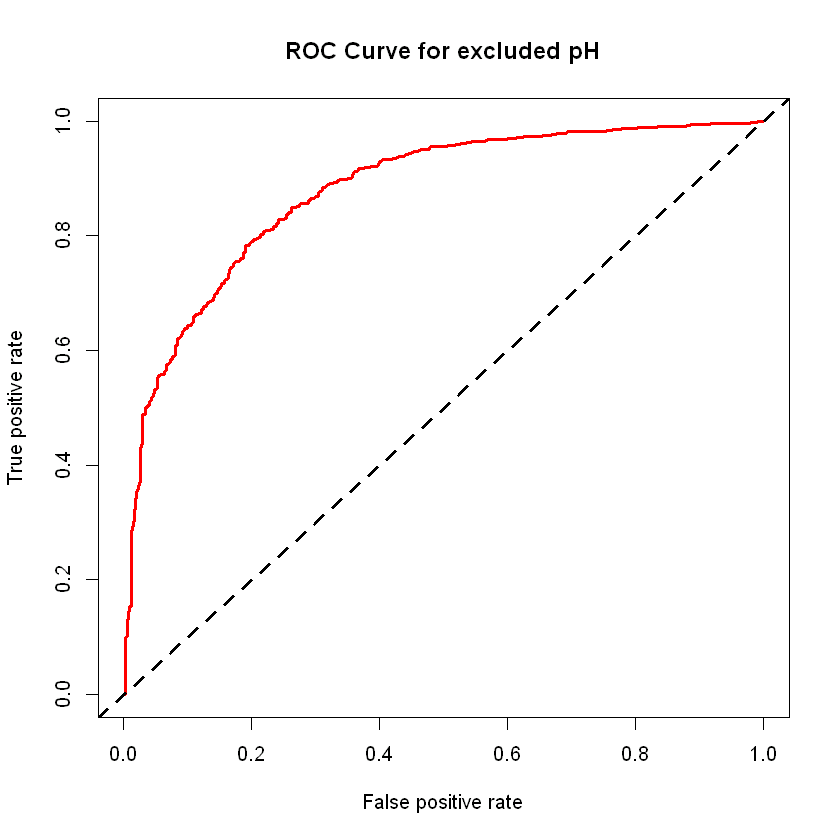

In [32]:
excluded_column <- "pH"
run_xgboost(excluded_column)

eXtreme Gradient Boosting 

4873 samples
  11 predictor
   2 classes: 'bad', 'good' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 4386, 4386, 4386, 4386, 4385, 4386, ... 
Resampling results:

  Accuracy  Kappa    
  0.810453  0.5822814

Tuning parameter 'nrounds' was held constant at a value of 100
Tuning
 held constant at a value of 1
Tuning parameter 'subsample' was held
 constant at a value of 1


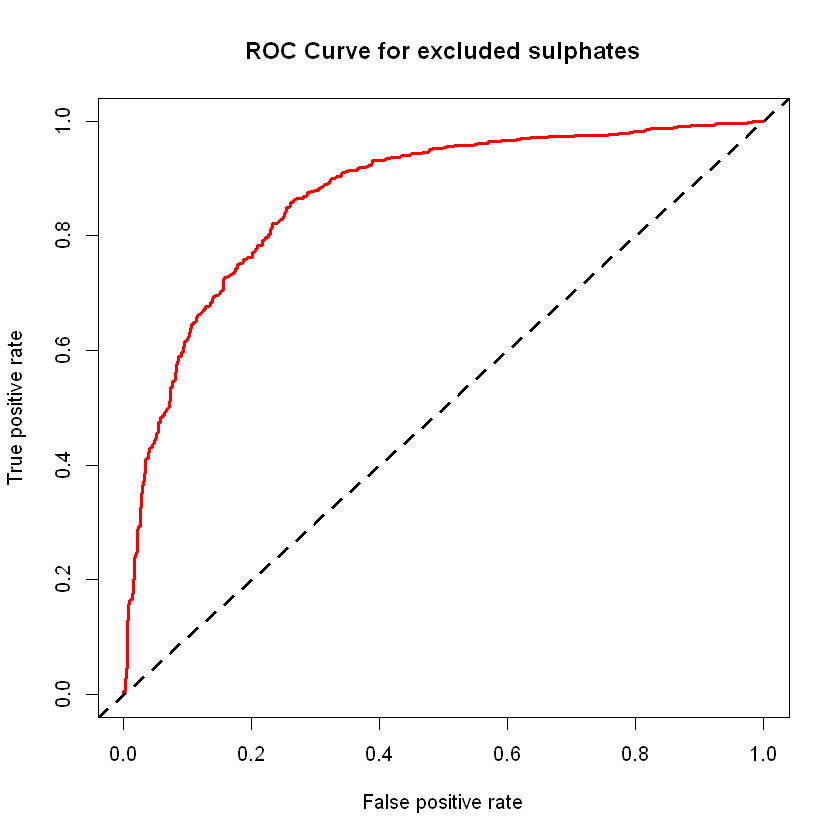

In [33]:
excluded_column <- "sulphates"
run_xgboost(excluded_column)

eXtreme Gradient Boosting 

4873 samples
  11 predictor
   2 classes: 'bad', 'good' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 4386, 4386, 4386, 4386, 4385, 4386, ... 
Resampling results:

  Accuracy   Kappa    
  0.8067629  0.5755718

Tuning parameter 'nrounds' was held constant at a value of 100
Tuning
 held constant at a value of 1
Tuning parameter 'subsample' was held
 constant at a value of 1


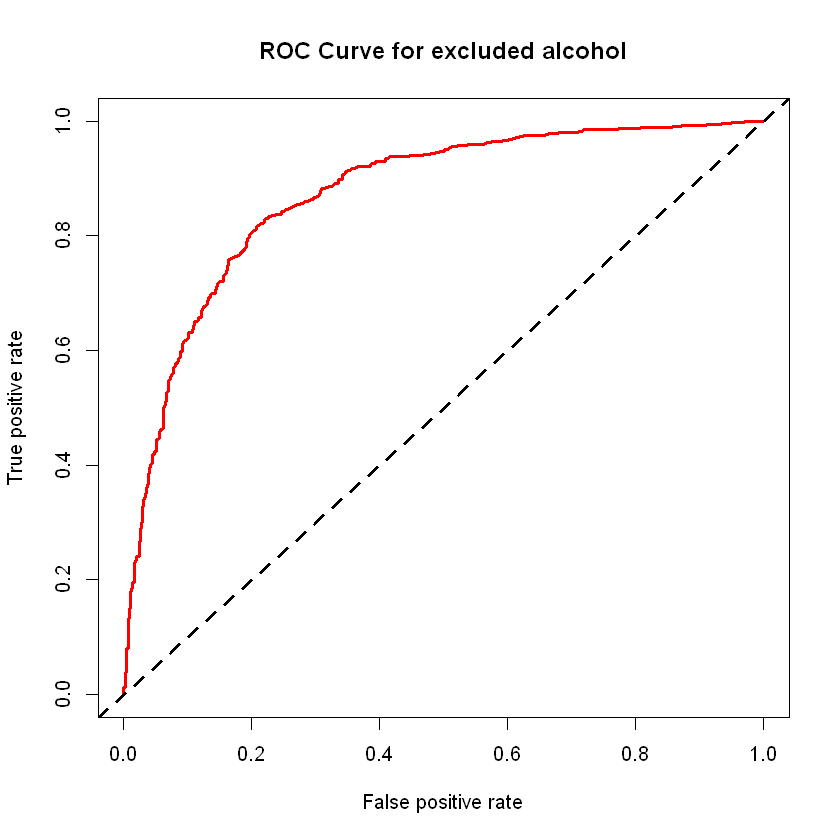

In [34]:
excluded_column <- "alcohol"
run_xgboost(excluded_column)

eXtreme Gradient Boosting 

4873 samples
  11 predictor
   2 classes: 'bad', 'good' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 4386, 4386, 4386, 4386, 4385, 4386, ... 
Resampling results:

  Accuracy  Kappa    
  0.816954  0.5977514

Tuning parameter 'nrounds' was held constant at a value of 100
Tuning
 held constant at a value of 1
Tuning parameter 'subsample' was held
 constant at a value of 1


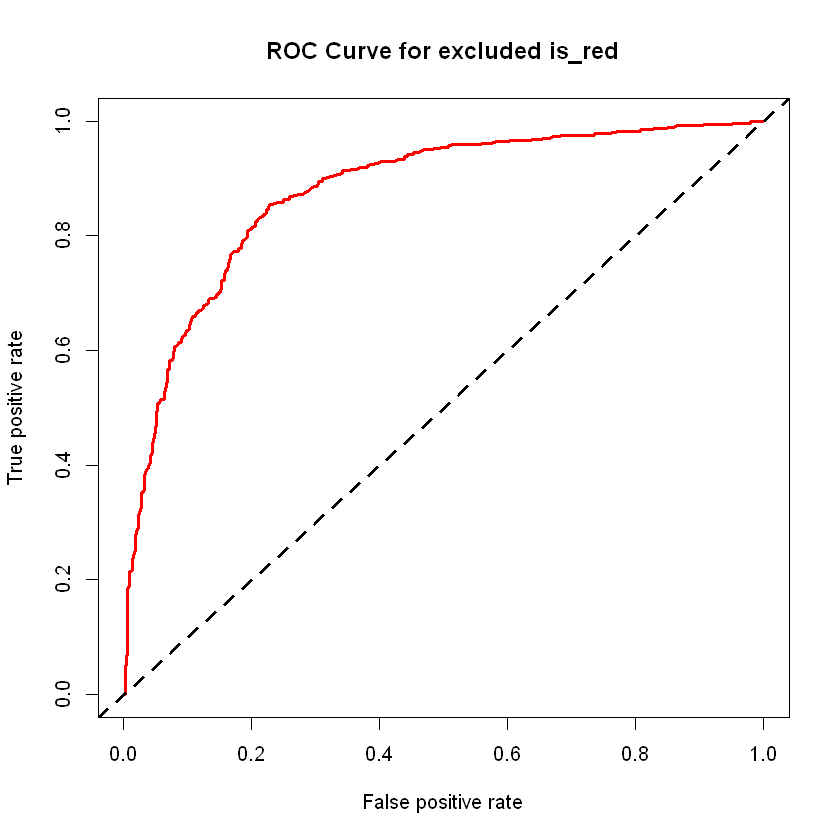

In [35]:
excluded_column <- "is_red"
run_xgboost(excluded_column)

In [37]:
# KONIEC #